## Detecting Myocardial Infarction

The method and model are based on this article : https://arxiv.org/abs/1805.00794

### Let's start with some imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
%config IPCompleter.greedy=True

### Fetching data

In [3]:
# 15-lead Dataset
df_ptbdb_normal = pd.read_csv('./combined_control1.csv', header=None)
df_ptbdb_abnormal = pd.read_csv('./combined_mi1.csv', header=None)

# Lead ii Dataset
#df_ptbdb_normal = pd.read_csv('./data/ptbdb_normal.csv', header=None)
#df_ptbdb_abnormal = pd.read_csv('./data/ptbdb_abnormal.csv', header=None)

df_ptbdb = pd.concat([df_ptbdb_normal, df_ptbdb_abnormal], axis=0)
print(df_ptbdb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56345 entries, 0 to 41870
Columns: 501 entries, 0 to 500
dtypes: float64(501)
memory usage: 215.8 MB
None


The PTBHB dataset is constituted of 14552 beats, labeled with two different classes : 

    '0' for normal beat
    '1' for abnormal beat (Myocardial infarction)

All the beats are recorded with 187 points. The shorter beats are padded with zeros to reach 187.

## Visualization of the dataset

In [4]:
# ptbdb
M_ptbdb = df_ptbdb.values
X_ptbdb = M_ptbdb[:,:-1]
y_ptbdb = M_ptbdb[:,-1]

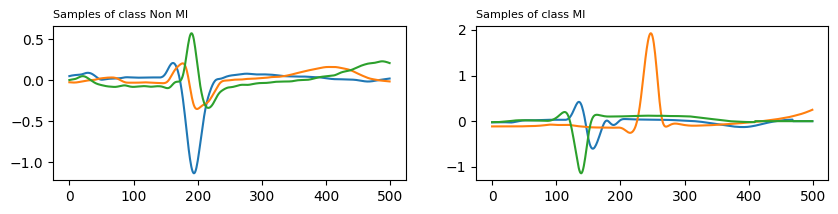

In [5]:
classes={0:"Non MI", 1:"MI"}
plt.figure(figsize=(10,2))
for i in range(0,2):
    plt.subplot(1,2,i + 1)
    all_samples_indexes = np.where(y_ptbdb == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_ptbdb[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc="left", fontdict={'fontsize':8})

## Model

In [6]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten, GRU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [7]:
input_shape = (500, 1) # Change 187 to 500 for 15-leads data input

def make_model(final_layer_size=5):
    I = Input(input_shape)
    C = Conv1D(filters=32, kernel_size=5)(I)

    C11 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(C)
    C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
    A11 = Add()([C, C12])
    R11 = Activation(activation='relu')(A11)
    M11 = MaxPool1D(pool_size=5, strides=2)(R11)

    C21 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M11)
    C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
    A21 = Add()([M11, C22])
    R21 = Activation(activation='relu')(A21)
    M21 = MaxPool1D(pool_size=5, strides=2)(R21)

    C31 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M21)
    C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
    A31 = Add()([M21, C32])
    R31 = Activation(activation='relu')(A31)
    M31 = MaxPool1D(pool_size=5, strides=2)(R31)

    C41 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M31)
    C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
    A41 = Add()([M31, C42])
    R41 = Activation(activation='relu')(A41)
    M41 = MaxPool1D(pool_size=5, strides=2)(R41)

    C51 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M41)
    C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
    A51 = Add()([M41, C52])
    R51 = Activation(activation='relu')(A51)
    M51 = MaxPool1D(pool_size=5, strides=2)(R51)

    G1 = GRU(units=40, return_sequences=True)(M51)

    F1 = Flatten()(G1)
    D1 = Dense(32)(F1)
    R1 = Activation(activation='relu')(D1)
    D2 = Dense(32)(R1)
    D3 = Dense(final_layer_size)(D2)

    O = Activation(activation='softmax')(D3)

    return Model(inputs=I, outputs=O)

"For training the networks, we used Adam optimization method with the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999, respectively. Learning rate is decayed exponentially with the decay factor of 0.75 every 10000 iterations."

In [8]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

### Detecting MI with ptbdb dataset only

In [9]:
n_classes = len(np.unique(y_ptbdb))
model_ptbdb = make_model(n_classes)
model_ptbdb.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 496, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 496, 32)   │      5,152 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 496, 32)   │      5,152 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 496, 32)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 496, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 246, 32)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 246, 32)   │      5,152 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 246, 32)   │      5,152 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 246, 32)   │          0 │ max_pooling1d[0]… │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 246, 32)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 121, 32)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 121, 32)   │      5,152 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 121, 32)   │      5,152 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 121, 32)   │          0 │ max_pooling1d_1[… │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 121, 32)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 59, 32)    │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 59, 32)    │      5,152 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 59, 32)    │      5,152 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 59, 32)    │          0 │ max_pooling1d_2[

 Total params: 77,106 (301.20 KB)

 Trainable params: 77,106 (301.20 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(X_ptbdb, y_ptbdb, test_size=0.15)

In [11]:
num_train_samples = X_train_ptbdb.shape[0]
print(f"Number of training samples: {num_train_samples}")

Number of training samples: 47893


In [12]:
unique_train, counts_train = np.unique(y_train_ptbdb, return_counts=True)
for label, count in zip(unique_train, counts_train):
    class_name = "MI" if label == 1 else "Non MI"
    print(f"Number of {class_name} samples in the training set: {count}")

Number of Non MI samples in the training set: 12326
Number of MI samples in the training set: 35567


In [13]:
model_ptbdb.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model_ptbdb.fit(np.expand_dims(X_train_ptbdb, axis=2), 
                          y_train_ptbdb, 
                          validation_split=0.15,
                          epochs=30,
                          batch_size=256,
                          verbose=1)

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 143ms/step - accuracy: 0.7638 - loss: 0.5195 - val_accuracy: 0.8138 - val_loss: 0.3937
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.8197 - loss: 0.3851 - val_accuracy: 0.8030 - val_loss: 0.4023
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8458 - loss: 0.3356 - val_accuracy: 0.8793 - val_loss: 0.2739
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.8822 - loss: 0.2696 - val_accuracy: 0.8728 - val_loss: 0.2803
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9030 - loss: 0.2289 - val_accuracy: 0.9154 - val_loss: 0.1963
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9423 - loss: 0.1407 - val_accuracy: 0.9532 - val_loss: 0.1207
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.9559 - loss: 0.1115 - val_accuracy: 0.9421 - val_loss: 0.1440
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9585 - loss: 0

In [15]:
def plot_learning(history):
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.legend(["accuracy"])
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.legend(["loss", "val_loss"])
    plt.show()
    

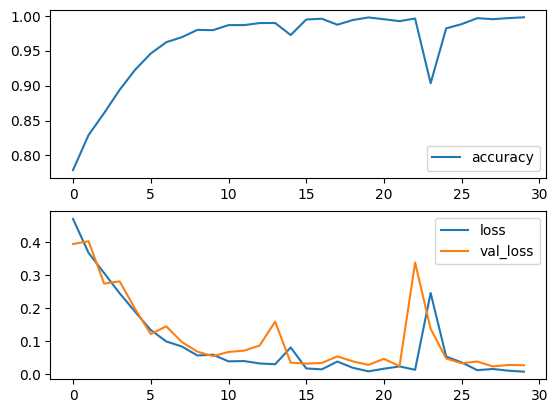

In [16]:
plot_learning(history)

The loss converges at around 15 epochs.

In [22]:

# Loading pretrained model
# model_filename = "saved_model_20240721_183018_CNN-GRU_99.8.keras"
# model_ptbdb = tf.keras.models.load_model(model_filename)

Let's try on the testing set.

In [17]:
unique, counts = np.unique(y_test_ptbdb, return_counts=True)
print(f"The testing set contains {counts[0]} normal recordings and {counts[1]} with myocardial infarction.\nLet's compute the confusion matrix.")

The testing set contains 2148 normal recordings and 6304 with myocardial infarction.
Let's compute the confusion matrix.


In [18]:
results = model_ptbdb.evaluate(np.expand_dims(X_test_ptbdb, axis=2), y_test_ptbdb, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9927 - loss: 0.0261
The accuracy on the testing set is 99.2%


In [19]:
y_pred_ptbdb = model_ptbdb.predict(np.expand_dims(X_test_ptbdb, axis=2))
y_pred_ptbdb_bool = np.argmax(y_pred_ptbdb, axis=1)
print(classification_report(y_test_ptbdb, y_pred_ptbdb_bool))

confusion_matrix = tf.math.confusion_matrix(y_test_ptbdb, y_pred_ptbdb_bool)
print(f"Confusion matrix :\n {confusion_matrix}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2148
         1.0       0.99      1.00      0.99      6304

    accuracy                           0.99      8452
   macro avg       0.99      0.99      0.99      8452
weighted avg       0.99      0.99      0.99      8452

Confusion matrix :
 [[2104   44]
 [  24 6280]]


In [20]:
print(f"{confusion_matrix[0][0]}/{counts[0]} Non MI were correctly classified")

print(f"{confusion_matrix[1][1]}/{counts[1]} MI were correctly classified")

print(f"{confusion_matrix[1][0]} MI were classified as Non MI")

print(f"{confusion_matrix[0][1]} Non MI were classified as MI")


2104/2148 Non MI were correctly classified
6280/6304 MI were correctly classified
24 MI were classified as Non MI
44 Non MI were classified as MI


In [25]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# محاسبه ماتریس اشتباهات
conf_matrix = tf.math.confusion_matrix(y_test_ptbdb, y_pred_ptbdb_bool)

# تبدیل ماتریس اشتباهات به آرایه numpy
conf_matrix_np = conf_matrix.numpy()

# استخراج مقادیر TP, TN, FP, FN
TN, FP, FN, TP = conf_matrix_np.ravel()

# محاسبه حساسیت و ویژگی
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


Sensitivity: 1.00
Specificity: 0.98


In [20]:
# Save current model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"saved_model_{timestamp}.keras"

model_ptbdb.save(model_filename)

The results for detecting MI by training directly with the ptbdb dataset are excellent : precision, recall, f1 and accuracy are all at around 0,99 on the testing set.